In [1]:
#导入必要的库
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#读取从有人云平台上下载的数据文件
wm_data=pd.read_excel("watermeter data1.xlsx")
wm_data=wm_data.fillna(0)

In [3]:
#将数据文件中的日期信息和时间信息单独提取
wm_data['日期计算']=pd.to_datetime(wm_data['日期计算'],format='%Y-%m-%d')
wm_data['时间计算']=pd.to_datetime(wm_data['时间计算'],format='%H:%M:%S')

In [4]:
# 定义函数selectdate，目的是提取有用的关键数据点，步骤如下：
# 从原始数据中，提出某一天的数据，并按时间从晚到早排序，计算两个时间之间的时间差，得到wm_data1的dataframe
# 从数据中筛出前后两个差360秒的数据，得到wm_data2的dataframe
def selectdate(date):
    wm_data1=wm_data[wm_data['日期计算']==pd.to_datetime(date)]
    wm_data1=wm_data1.loc[:,['时间计算','累计流量','数据L/s']]
    # wm_data1 = wm_data1[wm_data1.index % 2== 0]  #默认数据升点δQ=1L，修改这一行可以改成2L、3L等
    wm_data1= wm_data1.sort_values(by='时间计算', ascending=False)
    wm_data1['错位时间'] = wm_data1["时间计算"].shift(1)
    wm_data1['时间差']= wm_data1['错位时间']-wm_data1["时间计算"]
    wm_data1['时间差秒'] = wm_data1['时间差'] / np.timedelta64(1, 's')
    wm_data2=wm_data1[wm_data1['时间差秒']>360].copy() #wm_data2这个数据框仅包含前后时间差大于360秒的关键数据点
    wm_data2=pd.concat([wm_data2,wm_data1.head(1)], ignore_index=True)
    wm_data2= wm_data2.sort_values(by='时间计算', ascending=False)
    wm_data2=wm_data2.reset_index()
    return wm_data1,wm_data2

In [5]:
# 定义函数flow_calc，目的是计算关键数据点之间的流量差，并赋用水行为，步骤如下：
# 从数据中计算前后两个时间差360s的流量差，并判断流量的变化量范围，赋予颜色
def flow_calc(wm_data2):
    wm_data2['错位流量']= wm_data2["累计流量"].shift(-1)
    wm_data2['区间流量']=  1000*(wm_data2["累计流量"]-wm_data2["错位流量"])
    wm_data2['用水行为'] = ""
    wm_data2.loc[wm_data2["区间流量"] > 25,"用水行为"] = "冲洗用水"
    wm_data2.loc[(wm_data2["区间流量"] > 6.5) &(wm_data2["区间流量"] <= 25),"用水行为"] = "桶箱用水"
    wm_data2.loc[wm_data2["区间流量"] <= 6.5,"用水行为"] = "零星用水"
    wm_data2["颜色"]=""
    wm_data2.loc[wm_data2["用水行为"]=="冲洗用水","颜色"] ="white"
    wm_data2.loc[wm_data2["用水行为"]=="桶箱用水","颜色"] ="lightgray"
    wm_data2.loc[wm_data2["用水行为"]=="零星用水","颜色"] ="dimgray"
    wm_data2.drop(wm_data2.index[-1], inplace=True)
    return wm_data2

In [6]:
#定义函数plotting，用于画图
#需要画图的数据
def plotting(wm_data1,wm_data2,givendate):
    time = wm_data1["时间计算"].values
    acc_flow = wm_data1["累计流量"].values
    flow_rate = wm_data1["数据L/s"].values
    time2= wm_data2["时间计算"].values
    acc_flow2 = wm_data2["累计流量"].values
    inter_flow= wm_data2["区间流量"].values
    activity= wm_data2["用水行为"].values
    color2=wm_data2["颜色"].values
    plt.rcParams['font.family'] = ['Times New Roman','SimSun']
    fig, ax1 = plt.subplots(figsize=(11, 4))
    fig.patch.set_facecolor('white')
    color = 'black'
    ax1.set_ylabel('Qt (m³)',color=color, fontdict={'size': 16})
    ax1.tick_params(axis='x', labelsize=14)
    ax1.tick_params(axis='y',labelcolor=color, labelsize=14)
    a = ax1.plot(time, acc_flow, c=color, label="累计流量",linewidth=0.5)
    plt.scatter(time2, acc_flow2, c=color2,s =35*inter_flow,marker = "o",alpha =.9,edgecolor="black",linewidth=0.3)
    plt.scatter(time, acc_flow, c="black", s = 6,marker = "o")
    plt.ylim(wm_data2['累计流量'].min()-0.05,wm_data2['累计流量'].max()+0.05)
    ax1.grid(True)
    ax2 = ax1.twinx()  # 创建共用x轴的第二个y轴
    color = 'black'
    ax2.set_ylabel('q (L/s)', color=color,  fontdict={'size': 16})
    ax2.tick_params(axis='y', labelcolor=color, labelsize=14)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.scatter(time,flow_rate, c='black', s =17, marker = "x",linewidth=.7)
    plt.xlim(np.datetime64('1900-01-01T00:00:00'),np.datetime64('1900-01-02T00:00:00'))
    plt.ylim(-0.01,0.26)
    ax2.grid(False)
    plt.title(givendate,fontsize=18)
    plt.savefig(date)
    plt.show()

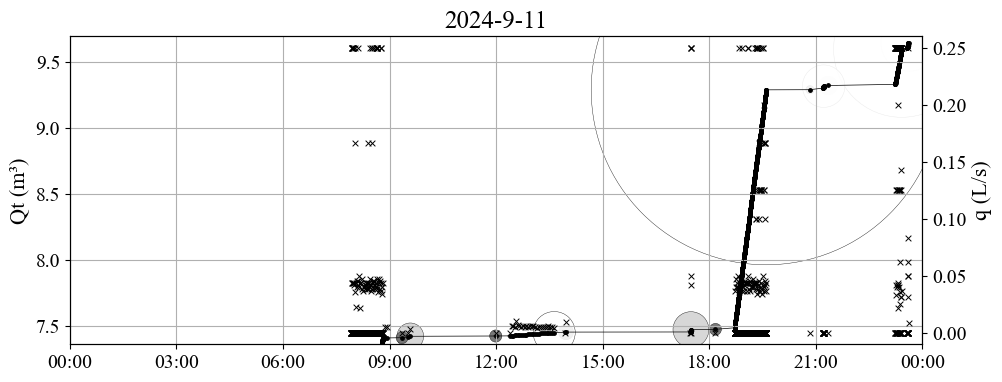

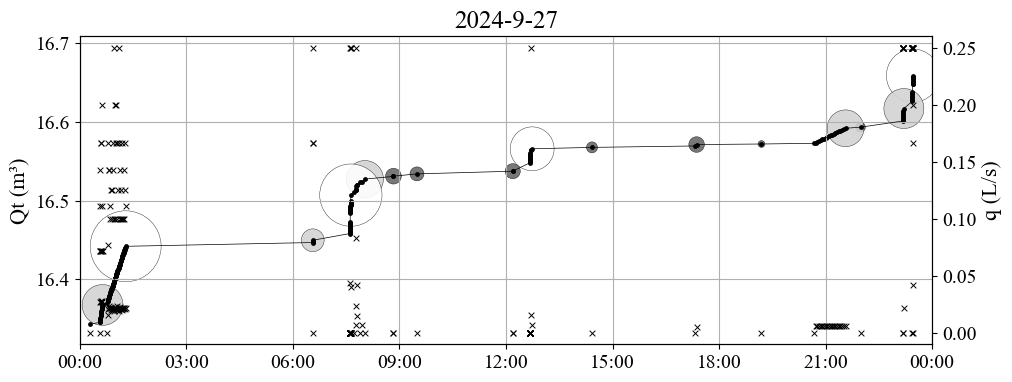

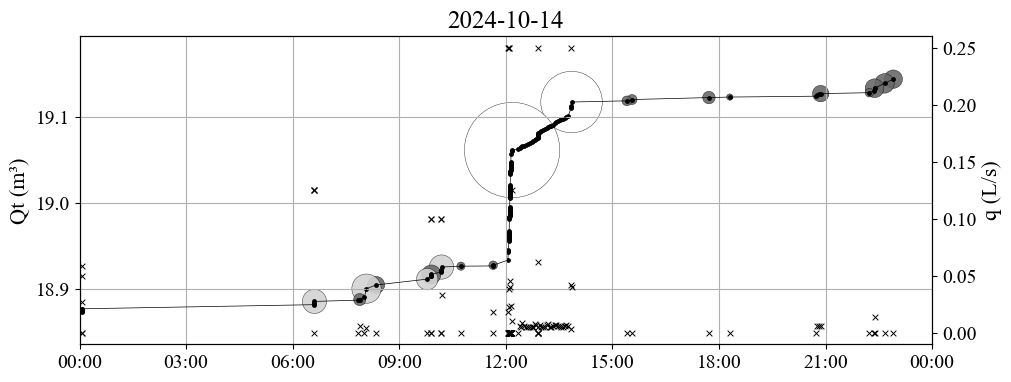

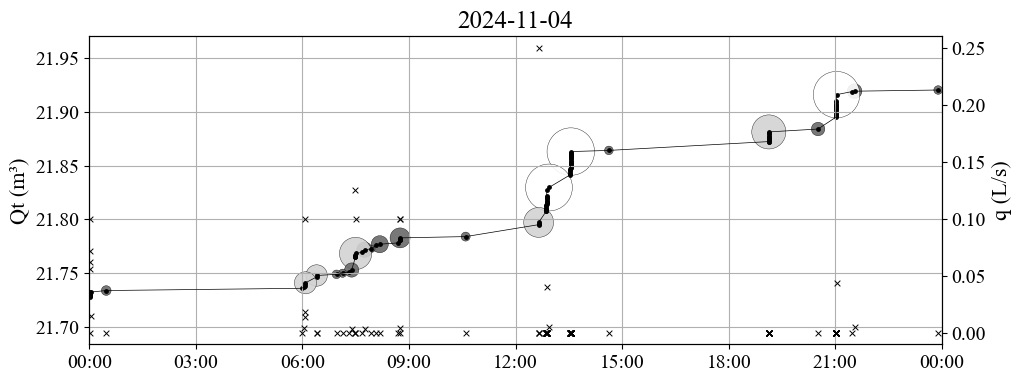

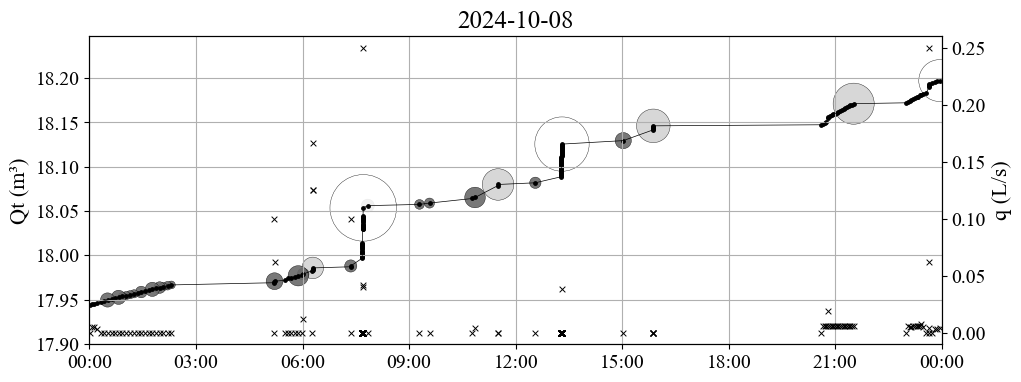

In [7]:
#指定要画图的日期
datenum=["2024-9-11","2024-9-27","2024-10-14","2024-11-04","2024-10-08"]
for date in datenum:
    wmdata,wmdata2=selectdate(date)
    wmdata2=flow_calc(wmdata2)
    plotting(wmdata,wmdata2,date)